<a href="https://colab.research.google.com/github/ggonzalesd/Deep-Learning-Project/blob/dev/project_model_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/models_02.py --output models_02.py
!curl $URL_BASE/test_models_02.py --output test_models_02.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0  40564      0 --:--:-- --:--:-- --:--:-- 40564
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0  11851      0 --:--:-- --:--:-- --:--:-- 11636
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2992  100  2992    0     0  54400      0 --:--:-- --:--:-- --:--:-- 54400
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5468  100  5468    0     0  65879      0 --:--:-- --:--:-- --:--:-- 65879


In [6]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more
from tqdm import tqdm

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_02 import BrainNetv1, BrainGoogleNet, BrainNetv2, BrainNetv3, BrainNetv4

# Preprocessing Dataset | (from .mat to .npy) 📥
Download and unzip dataset

In [7]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  838M  100  838M    0     0  26.7M      0  0:00:31  0:00:31 --:--:-- 28.5M
mkdir: cannot create directory ‘dataset’: File exists
Archive:  data.zip
 extracting: ./tmp_dataset/brainTumorDataPublic_1-766.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_1533-2298.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_767-1532.zip  
 extracting: ./tmp_dataset/brainTumorDataPublic_2299-3064.zip  
 extracting: ./tmp_dataset/cvind.mat  
 extracting: ./tmp_dataset/README.txt  
Archive:  ./tmp_dataset/brainTumorDataPublic_1533-2298.zip
  inflating: ./tmp_dataset/1533.mat  
  inflating: ./tmp_dataset/1534.mat  
  inflating: ./tmp_dataset/1535.mat  
  inflating: ./tmp_dataset/1536.mat  
  inflating: ./tmp_dataset/1537.mat  
  inflating: ./tmp_dataset/1538.mat  
  inflating: ./tmp_dataset/1539.mat  
  inflating: ./tmp_dataset/1540.mat

Convert .mat to .npy

In [8]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in tqdm(range(3064)):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

100%|██████████| 3064/3064 [01:02<00:00, 48.94it/s]


save Labels

In [9]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

# Config Device and Seed 🖥 🎲

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [11]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Load Dataset and Create DataLoaders 💽

In [12]:
# Load Dataset
BATCH_SIZE = 32
TEST_BATCH_SIZE = 16
EPOCHS = 5
HEADERS = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]

dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = plots.split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [13]:
# Split train_data for training and validation
train_set, val_set = plots.split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [14]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  39


# Visualization of Dataset 👀

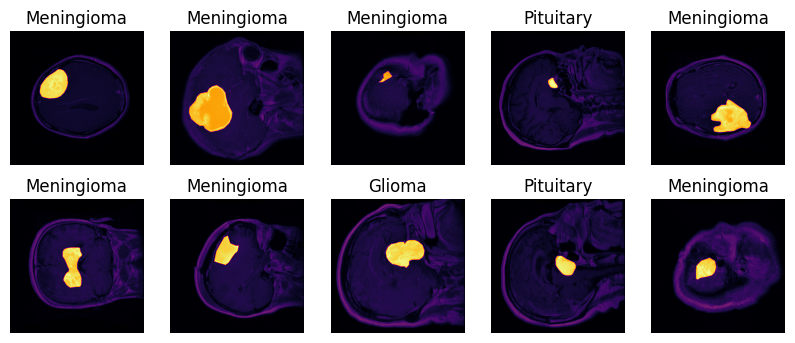

In [15]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()

  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

# Testing

In [24]:
!python -m pytest test_models_02.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.2.0
rootdir: /content
plugins: anyio-3.7.0
collected 5 items                                                              

test_models_02.py .....                                                  [100%]

============================== 5 passed in 9.88s ===============================


# Training 💪 🏋️

# Brain Net V1

In [17]:
model = BrainNetv1()
brainnet_v1_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

brainnet_v1_ckp = ModelCheckpoint('brainnet_v1_lr3.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v1_ckp)

brainnet_v1_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/5): time=00:56, train_loss=0.464, train_acc=0.816, train_f1=0.811, val_loss=1.693, val_acc=0.620, val_f1=0.528


Epoch 2/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/5): time=00:45, train_loss=0.255, train_acc=0.910, train_f1=0.910, val_loss=1.356, val_acc=0.674, val_f1=0.605


Epoch 3/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/5): time=00:41, train_loss=0.168, train_acc=0.939, train_f1=0.939, val_loss=0.312, val_acc=0.877, val_f1=0.883


Epoch 4/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/5): time=00:34, train_loss=0.165, train_acc=0.939, train_f1=0.939, val_loss=0.368, val_acc=0.866, val_f1=0.865


Epoch 5/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/5): time=00:42, train_loss=0.116, train_acc=0.960, train_f1=0.960, val_loss=1.069, val_acc=0.677, val_f1=0.686


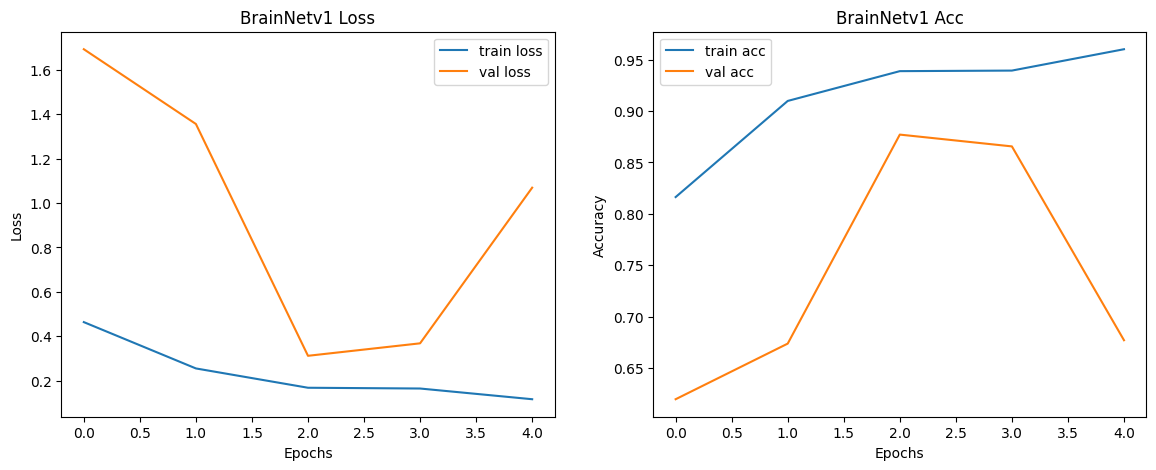

In [18]:
plots.plot_model_results("BrainNetv1", brainnet_v1_results)

In [31]:
plots.print_table(HEADERS,
  [plots.row("BrainNet V1", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params]]
)

+-------------+------------+----------+-----------+---------+----------+
|    Model    | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------+------------+----------+-----------+---------+----------+
| BrainNet V1 |   0.168    |  0.312   |   0.939   |  0.877  |  413047  |
+-------------+------------+----------+-----------+---------+----------+


In [37]:
model = BrainNetv4()
brainnet_v4_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

brainnet_v4_ckp = ModelCheckpoint('brainnet_v4_lr3.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v4_ckp)

brainnet_v4_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/5): time=00:28, train_loss=0.418, train_acc=0.835, train_f1=0.833, val_loss=0.483, val_acc=0.821, val_f1=0.826


Epoch 2/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/5): time=00:26, train_loss=0.225, train_acc=0.923, train_f1=0.923, val_loss=0.914, val_acc=0.659, val_f1=0.679


Epoch 3/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/5): time=00:26, train_loss=0.195, train_acc=0.929, train_f1=0.929, val_loss=0.615, val_acc=0.770, val_f1=0.745


Epoch 4/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/5): time=00:26, train_loss=0.177, train_acc=0.938, train_f1=0.938, val_loss=0.803, val_acc=0.721, val_f1=0.679


Epoch 5/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/5): time=00:26, train_loss=0.122, train_acc=0.960, train_f1=0.960, val_loss=0.342, val_acc=0.884, val_f1=0.885


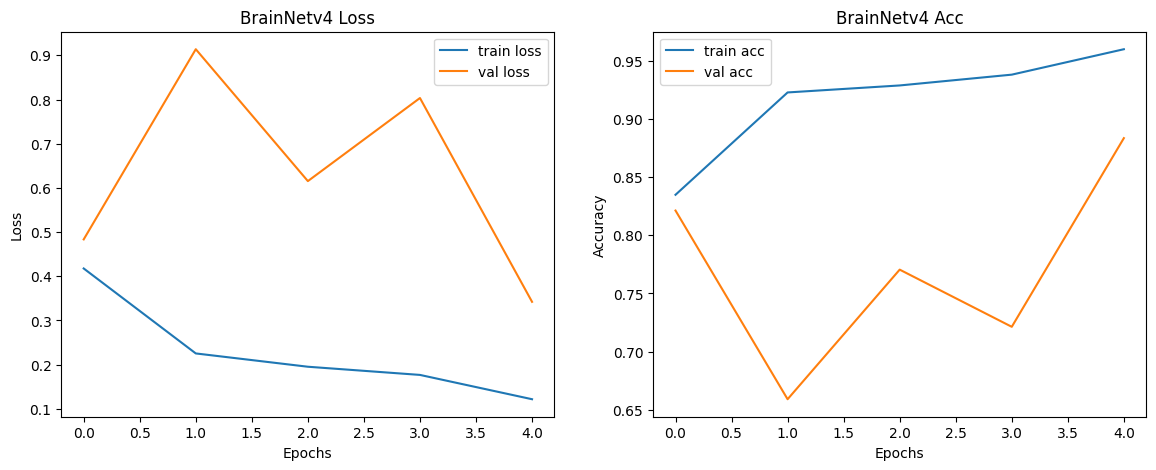

In [40]:
plots.plot_model_results("BrainNetv4", brainnet_v4_results)

In [43]:
plots.print_table(HEADERS,
  [plots.row("BrainNet V1", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params],
   plots.row("BrainNet V4", brainnet_v4_ckp.best_results) + [brainnet_v4_num_params]]
)

+-------------+------------+----------+-----------+---------+----------+
|    Model    | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------+------------+----------+-----------+---------+----------+
| BrainNet V1 |   0.168    |  0.312   |   0.939   |  0.877  |  413047  |
| BrainNet V4 |   0.122    |  0.342   |   0.960   |  0.884  |  403987  |
+-------------+------------+----------+-----------+---------+----------+


# Brain VGG19 Net Fine Tuning

In [25]:
model = BrainGoogleNet()
braingooglenet_lr4_wr8_num_params = plots.total_num_parameters(model)

feat_params = list(model.backbone.parameters())
clf_params = list(model.classifier.parameters())

parameters = [
    {'params': feat_params, 'lr':1e-3, 'weight_decay': 1e-10},
    {'params': clf_params, 'lr':1e-4, 'weight_decay': 1e-8},
]

optimizer = optim.AdamW(parameters)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

braingooglenet_finetuning_ckp = ModelCheckpoint('braingooglenet_finetuning.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(braingooglenet_finetuning_ckp, three_channels=True)

braingooglenet_finetuning_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

Epoch 1/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/5): time=01:17, train_loss=0.271, train_acc=0.904, train_f1=0.904, val_loss=1.143, val_acc=0.749, val_f1=0.692, lr=0.001


Epoch 2/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/5): time=01:01, train_loss=0.137, train_acc=0.952, train_f1=0.952, val_loss=1.048, val_acc=0.626, val_f1=0.551, lr=0.001


Epoch 3/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/5): time=01:34, train_loss=0.114, train_acc=0.963, train_f1=0.963, val_loss=0.709, val_acc=0.713, val_f1=0.708, lr=0.001


Epoch 4/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/5): time=00:51, train_loss=0.061, train_acc=0.981, train_f1=0.981, val_loss=0.306, val_acc=0.898, val_f1=0.900, lr=0.001


Epoch 5/5:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/5): time=00:50, train_loss=0.028, train_acc=0.995, train_f1=0.995, val_loss=0.270, val_acc=0.908, val_f1=0.902, lr=0.001


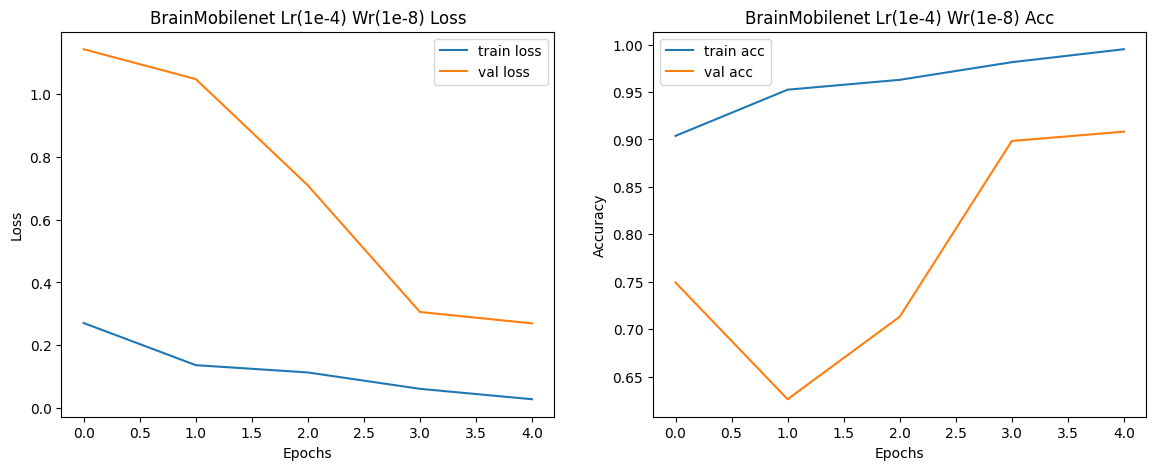

In [26]:
plots.plot_model_results("BrainMobilenet Lr(1e-4) Wr(1e-8)", braingooglenet_finetuning_results)

In [46]:
plots.print_table(HEADERS,
[
plots.row("BrainNet V1", brainnet_v1_ckp.best_results) + [brainnet_v1_num_params],
  plots.row("BrainNet V4", brainnet_v4_ckp.best_results) + [brainnet_v4_num_params],
plots.row("BrainGooglenet",braingooglenet_finetuning_ckp.best_results)+[braingooglenet_lr4_wr8_num_params]
])

+----------------+------------+----------+-----------+---------+----------+
|     Model      | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+----------------+------------+----------+-----------+---------+----------+
|  BrainNet V1   |   0.168    |  0.312   |   0.939   |  0.877  |  413047  |
|  BrainNet V4   |   0.122    |  0.342   |   0.960   |  0.884  |  403987  |
| BrainGooglenet |   0.028    |  0.270   |   0.995   |  0.908  | 5602979  |
+----------------+------------+----------+-----------+---------+----------+


In [47]:
best_model = BrainGoogleNet()
best_model = best_model.to(device)
braingooglenet_finetuning_ckp.load_checkpoint(best_model)

In [49]:
def predict_labels(model, test_dl):
  y_pred = []
  y_true = []

  model.eval()

  with torch.no_grad():
    for X, y in test_dl:
      X = torch.concat([X, X.mean(1, keepdim=True)], 1)
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      y_pred.append(logits.detach().to('cpu'))
      y_true.append(y.detach().to('cpu'))
  return torch.concat(y_pred), torch.concat(y_true)

In [50]:
y_test_pred, y_test_true = predict_labels(best_model, test_dl)

In [51]:
print(f"Predictions size: {y_test_pred.size()}")
print(f"True Labels size: {y_test_true.size()}")

Predictions size: torch.Size([610, 3])
True Labels size: torch.Size([610])


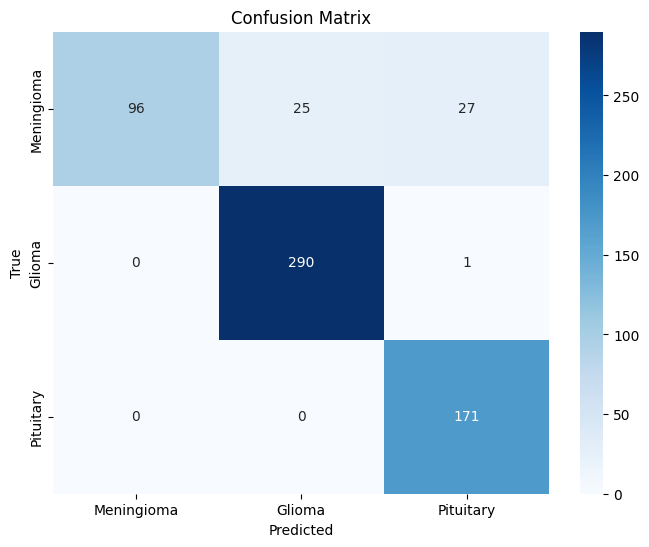

In [55]:
import torchmetrics
import seaborn as sns
CLASS_NAMES = ['Meningioma', 'Glioma', 'Pituitary']
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
  confusion_matrix = torchmetrics.ConfusionMatrix('multiclass', num_classes=3)
  confusion_matrix = confusion_matrix.to('cpu')
  cm = confusion_matrix(predicted_labels, true_labels).to('cpu')

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
plot_confusion_matrix(y_test_true, y_test_pred, CLASS_NAMES)